# Time-evolution of helium subject to a laser field using configuration interaction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from quantum_systems import construct_psi4_system
from quantum_systems.time_evolution_operators import LaserField
from configuration_interaction import TDCIS, TDCID, TDCISD
from configuration_interaction.integrators import GaussIntegrator

In [2]:
class LaserPulse:
    def __init__(self, t0=0, td=5, omega=0.1, E=0.03):
        self.t0 = t0
        self.td = td
        self.omega = omega
        self.E = E  # Field strength

    def __call__(self, t):
        T = self.td
        delta_t = t - self.t0
        return (
            -(np.sin(np.pi * delta_t / T) ** 2)
            * np.heaviside(delta_t, 1.0)
            * np.heaviside(T - delta_t, 1.0)
            * np.cos(self.omega * delta_t)
            * self.E
        )

In [3]:
# System parameters
He = """
He 0.0 0.0 0.0
symmetry c1
"""

options = {"basis": "cc-pvdz", "scf_type": "pk", "e_convergence": 1e-6}
omega = 2.873_564_3
E = 100
laser_duration = 5

system = construct_psi4_system(He, options)
system.change_to_hf_basis(verbose=True, tolerance=1e-15)

HF converged to given precision in 13 iterations
Ehf: -2.855160477242741


In [4]:
integrator = GaussIntegrator(s=3, np=np, eps=1e-6)
tdcisd = TDCISD(system, integrator=integrator, np=np, verbose=True)
tdcisd.compute_ground_state()
print(f"Ground state CISD energy: {tdcisd.compute_ground_state_energy()}")

Number of states to create: 45
Size of a state in bytes: 8
Time spent setting up CISD space: 0.05045032501220703 sec
Time spent constructing Hamiltonian: 2.2012600898742676 sec
Time spent diagonalizing Hamiltonian: 0.0004563331604003906 sec
Ground state CISD energy: -2.887594831090936


In [5]:
polarization = np.zeros(3)
polarization[2] = 1
system.set_time_evolution_operator(
    LaserField(
        LaserPulse(td=laser_duration, omega=omega, E=E),
        polarization_vector=polarization,
    )
)

In [6]:
tdcisd.set_initial_conditions()
dt = 1e-3
T = 5
num_steps = int(T // dt) + 1
t_stop_laser = int(laser_duration // dt) + 1

print(f"Number of steps: {num_steps}")
print(f"Laser stops at step: {t_stop_laser}")

time_points = np.linspace(0, T, num_steps)

td_energies = np.zeros(len(time_points), dtype=np.complex128)
dip_z = np.zeros(len(time_points))
td_overlap = np.zeros_like(dip_z)

rho_qp = tdcisd.compute_one_body_density_matrix(tol=1e6)
rho_qp_hermitian = 0.5 * (rho_qp.conj().T + rho_qp)

td_energies[0] = tdcisd.compute_energy()
dip_z[0] = np.einsum("qp,pq->", rho_qp_hermitian, system.dipole_moment[2]).real
td_overlap[0] = tdcisd.compute_time_dependent_overlap()

Number of steps: 5000
Laser stops at step: 5000


In [7]:
for i, c in tqdm.tqdm_notebook(
    enumerate(tdcisd.solve(time_points)), total=num_steps - 1
):
    td_energies[i + 1] = tdcisd.compute_energy()

    rho_qp = tdcisd.compute_one_body_density_matrix(tol=1e6)
    rho_qp_hermitian = 0.5 * (rho_qp.conj().T + rho_qp)

    dip_z[i + 1] = np.einsum("qp,pq->", rho_qp_hermitian, system.dipole_moment[2]).real
    td_overlap[i + 1] = tdcisd.compute_time_dependent_overlap()

Here we generate test-data for `TDCISD`.

```python
np.savetxt("tdcisd_helium_energies_real.dat", td_energies.real)
np.savetxt("tdcisd_helium_overlap.dat", td_overlap)
np.savetxt("tdcisd_helium_dipole_z.dat", dip_z)
```

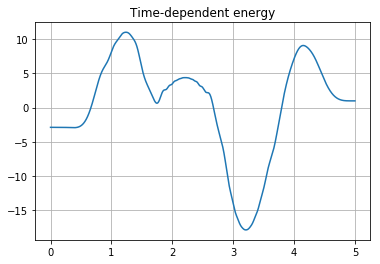

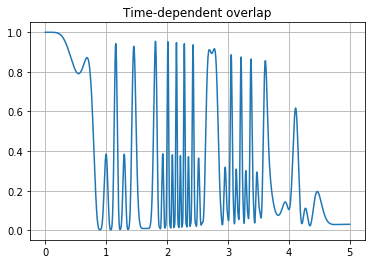

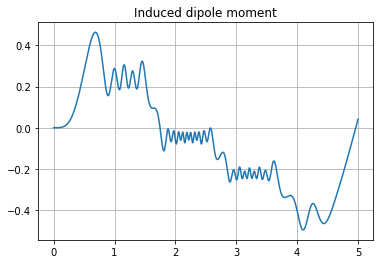

In [8]:
plt.figure()
plt.plot(time_points, td_energies.real)
plt.title("Time-dependent energy")
plt.grid()

plt.figure()
plt.plot(time_points, td_overlap)
plt.title("Time-dependent overlap")
plt.grid()

plt.figure()
plt.plot(time_points, dip_z)
plt.title("Induced dipole moment")
plt.grid()

plt.show()